## This script contains the following sections:
### 1. Import licraries and data
### 2. Feature Selection for Machine Learning
### 3. Building Decision Tree Model
### 4. Evaluating the Model
### 5. Optimizing Decision Tree Performance

## 1. Import Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

# Decision tree based imports
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# For train test split function and cross validation
from sklearn.model_selection import train_test_split, KFold, cross_val_score 
from sklearn import metrics # import scikit-learn metrics module for accuracy calculation

# to make compiler able to draw
import io
import sys
import matplotlib
%matplotlib inline
from IPython.display import display, Image

In [2]:
# set path
path = r'C:\Users\ksmak\Desktop\CareerFoundary\PigE Bank_Decision Tree'

In [3]:
# Import file
df = pd.read_csv(os.path.join(path, '02 Data', 'Working Data', 'churn modelling.csv'))

In [4]:
df.shape

(10000, 14)

In [5]:
df.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Defected
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [6]:
# Renaming columns
df.rename(columns={'Geography': 'Country'}, inplace=True)

In [7]:
# convert string or categorical data type to integer
d = {'France': 0, 'Germany': 1, 'Spain': 2}
df['Country'] = df['Country'].map(d)
d = {'Female': 1, 'Male': 0}
df['Gender'] = df['Gender'].map(d)

In [8]:
df.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Country,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Defected
0,1,15634602,Hargrave,619,0,1,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,2,1,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,0,1,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,0,1,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,2,1,43,2,125510.82,1,1,1,79084.10,0


In [9]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Country',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Defected'],
      dtype='object')

In [10]:
# Check for missing values
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Country            0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Defected           0
dtype: int64

In [11]:
# Automatically select numerical columns using select_dtypes
numcols = ['Age','Tenure', 'CreditScore','EstimatedSalary']

# Iterate over each numerical column
for i in numcols:
    # Calculate quartiles and IQR
    q75, q25 = np.percentile(df[i], [75, 25])
    iqr = q75 - q25
    
    # Calculate outlier boundaries
    min_val = q25 - (iqr * 1.5)
    max_val = q75 + (iqr * 1.5)
    
    # Filter out outliers
    df1 = df[(df[i] >= min_val) & (df[i] <= max_val)]


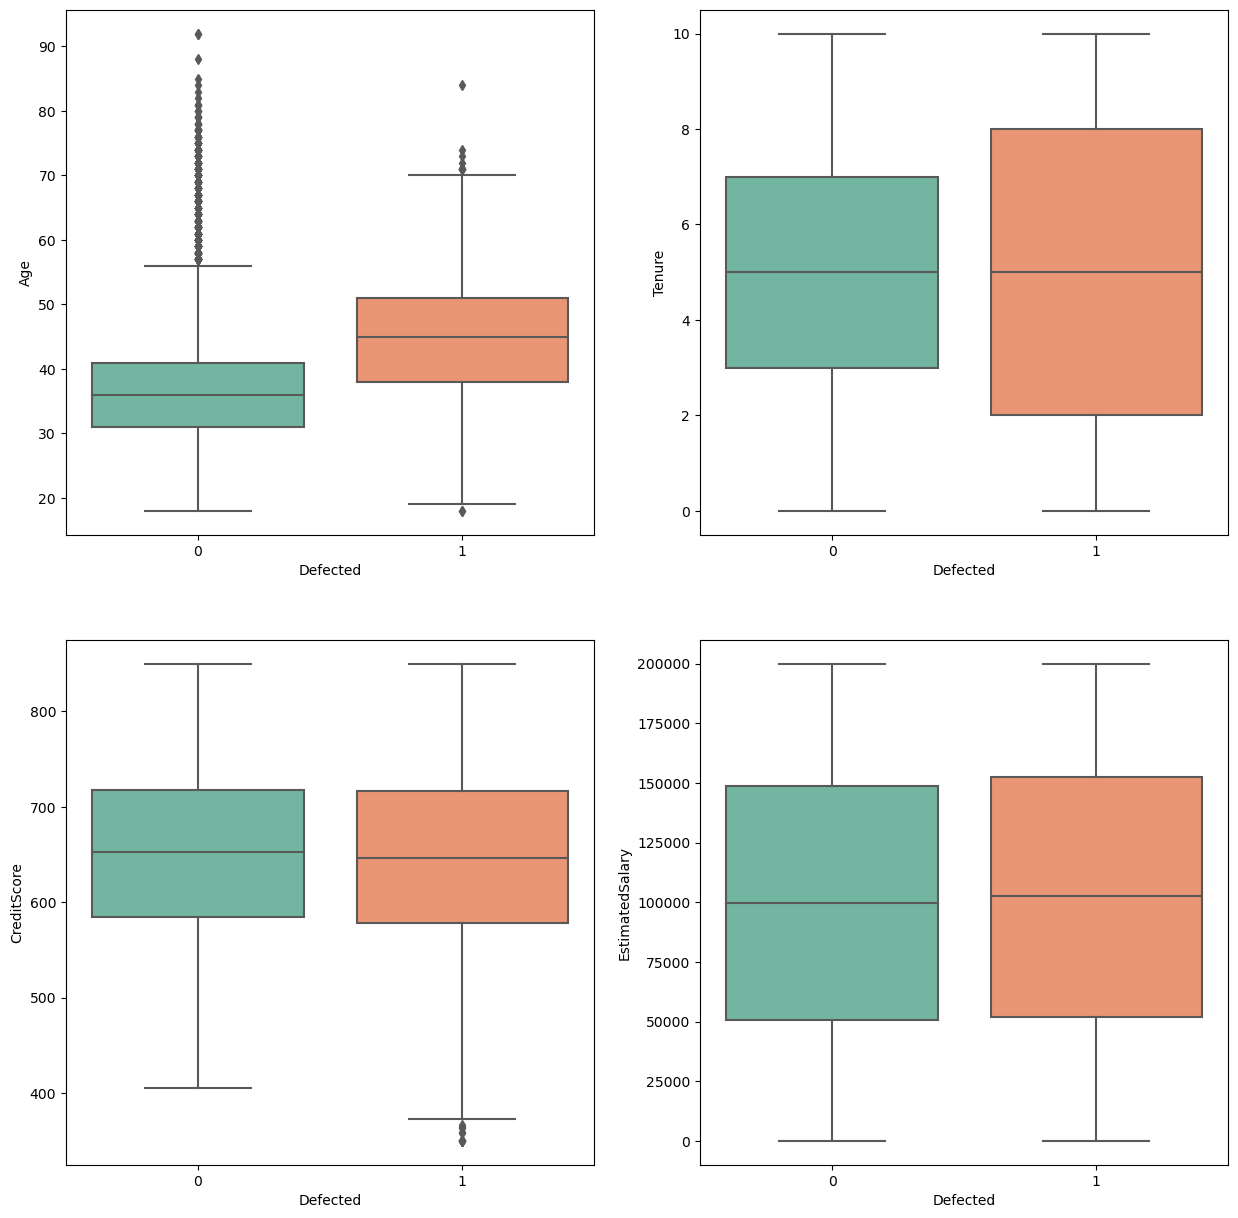

In [12]:
# Set the figure size and create subplots
fig, ax = plt.subplots(2, 2, figsize=(15, 15))

# Flatten the axes for easier iteration
for i, subplot in enumerate(ax.flatten()):
    # Plot a boxplot for each numerical column
    color_0_1 = sns.color_palette("Set2")[:2]
    sns.boxplot(x='Defected', y=numcols[i], data=df1, ax=subplot, palette=color_0_1) # 1 is leave and 0 is stay

# Save the plot to an image file (e.g., PNG or PDF)
plt.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'PigEBank_boxplots.png'), dpi=300, bbox_inches='tight')
    
# Show the plots
plt.show()


Tree-based algorithms are immune to feature scaling because different feature magnitudes and variances do not affect them. Therefore, it is unnecessary to scale the data. What about outliers?

### Counterplots to show trend of features

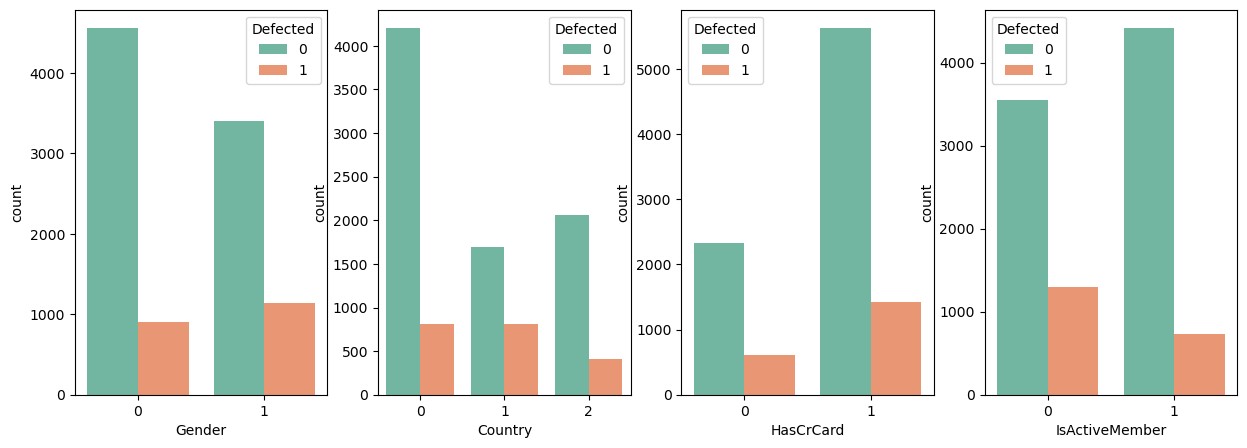

In [13]:
# Define categorical features
categorical_features = ['Gender', 'Country', 'HasCrCard', 'IsActiveMember']

# Set the figure size and create subplots
fig, ax = plt.subplots(1,4, figsize = (15,5))

# Flatten the axes for easier iteration
for i, subplot in zip(categorical_features, ax.flatten()):
    # Plot counterplots for each numerical column
    color_0_1 = sns.color_palette("Set2")[:2]
    sns.countplot(x = i, hue="Defected", data = df1, ax = subplot, palette=color_0_1 )
    
# Save the plot to an image file (e.g., PNG or PDF)
plt.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'PigEBank_counterplots.png'), dpi=300, bbox_inches='tight')
    
# Show the plots
plt.show()
    

There was a higher portion of women (1) left the bank, and surprisingly, customers with credit cards (1) left the bank as well. 

## 2. Features Selection

In [14]:
df1=df.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

In [15]:
df1.columns

Index(['CreditScore', 'Country', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Defected'],
      dtype='object')

In [16]:
df1.head()

,CreditScore,Country,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Defected
0,619,0,1,42,2,0.00,1,1,1,101348.88,1
1,608,2,1,41,1,83807.86,1,0,1,112542.58,0
2,502,0,1,42,8,159660.80,3,1,0,113931.57,1
3,699,0,1,39,1,0.00,2,0,0,93826.63,0
4,850,2,1,43,2,125510.82,1,1,1,79084.10,0


In [17]:
# Create a correlation matrix using pandas
df1.corr()

,CreditScore,Country,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Defected
CreditScore,1.000000,0.007888,0.002857,-0.003965,0.000842,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Country,0.007888,1.000000,-0.004719,0.022812,0.003739,0.069408,0.003972,-0.008523,0.006724,-0.001369,0.035943
Gender,0.002857,-0.004719,1.000000,0.027544,-0.014733,-0.012087,0.021859,-0.005766,-0.022544,0.008112,0.106512
Age,-0.003965,0.022812,0.027544,1.000000,-0.009997,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,0.000842,0.003739,-0.014733,-0.009997,1.000000,-0.012254,0.013444,0.022583,-0.028362,0.007784,-0.014001
Balance,0.006268,0.069408,-0.012087,0.028308,-0.012254,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.012238,0.003972,0.021859,-0.030680,0.013444,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,-0.005458,-0.008523,-0.005766,-0.011721,0.022583,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.025651,0.006724,-0.022544,0.085472,-0.028362,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.001384,-0.001369,0.008112,-0.007201,0.007784,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097


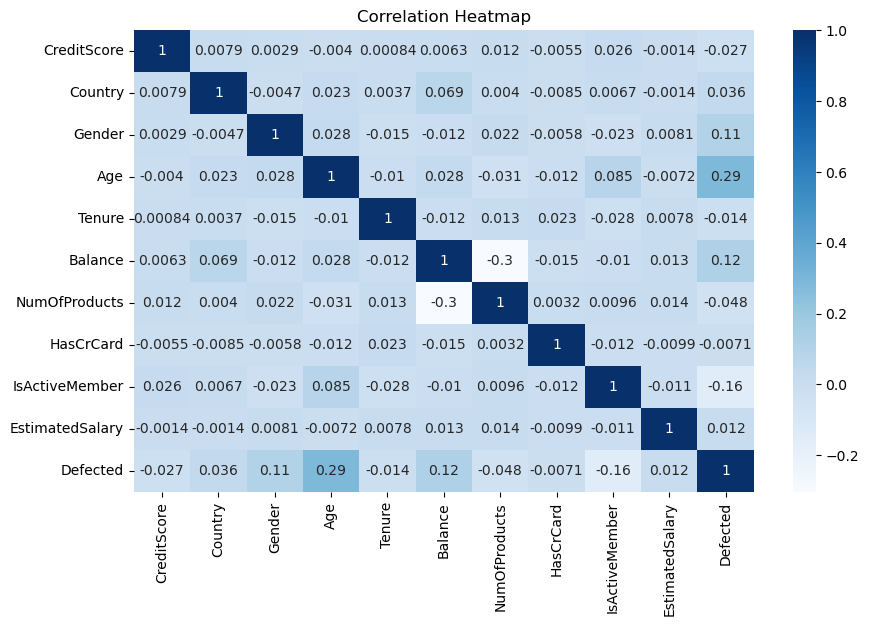

In [18]:
# Create a subplot with matplotlib
f,ax = plt.subplots(figsize=(10,6))

# Create the correlation heatmap in seaborn by applying a heatmap onto the correlation matrix and the subplots defined above.
corr = sns.heatmap(df1.corr(), cmap='Blues', annot = True, ax = ax) # The `annot` argument allows the plot to 
#place the correlation coefficients onto the heatmap.

# Set title
ax.set_title('Correlation Heatmap')

# Save the plot to an image file (e.g., PNG or PDF)
plt.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'PigEBank_CorrHeatmap.png'), dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

Age is the attribute that is stronly correlated with customer leaving or staying. It should be dropped for the machine learning because models trained on datasets with highly correlated features may perform well on the training data but struggle to generalize to new, unseen data. Impact: Removing correlated features helps improve a model's ability to generalize to new data, reducing the risk of overfitting and making the model more robust.

### Embeded Method: Decision Tree

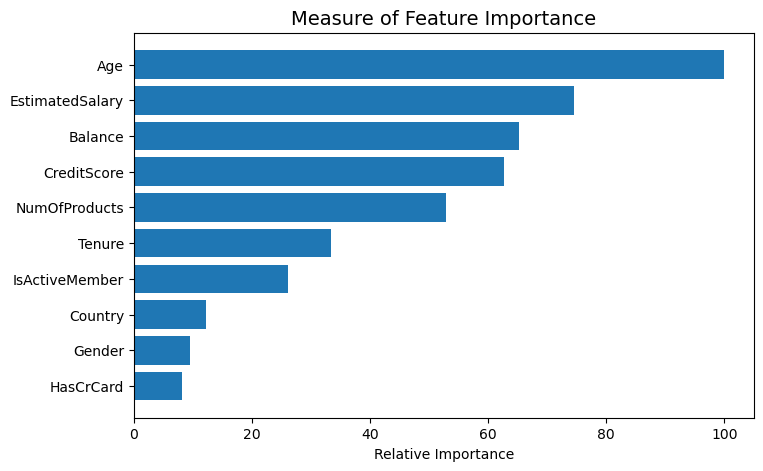

In [23]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import matplotlib.pyplot as plt
import os  # Import os module for file operations

features = df1.drop('Defected', axis=1)
target = df1['Defected']

classifier = DecisionTreeClassifier(random_state=11)
classifier.fit(features, target)

# Print the feature importances
feature_importance = classifier.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())

# Sort the feature importances from greatest to least using the sorted indices
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[-50:]  # Select the top 50 important features

pos = np.arange(sorted_idx.shape[0]) + 0.5

# Create a bar plot of the feature importances
plt.figure(figsize=(8, 5))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, features.columns[sorted_idx], size=10)  # Use columns attribute to access column names
plt.xlabel('Relative Importance', fontsize=10)
plt.title('Measure of Feature Importance', fontsize=14)

# Save the plot to an image file (e.g., PNG or PDF)
plt.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'PigEBank_DTVariable importance.png'), dpi=300, bbox_inches='tight')

plt.show()


In [24]:
# assign the variables to be used for the prediction
features = ['Age','EstimatedSalary', 'Balance','Tenure','CreditScore']

## 3. Building Decision Tree Model

### Define features and target

In [25]:
X = df1[features]
y = df1['Defected']

### Split data into train_test_split

In [26]:
# from sklearn.model_selection import train_test_split, KFold, cross_val_score 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) # 70% training and 30% test

### Create decision tree classifier object

In [27]:
# from sklearn.tree import DecisionTreeClassifier
dtree = tree.DecisionTreeClassifier(random_state=0, criterion='gini')

### Train decision tree classifies

In [28]:
dtree = dtree.fit(X_train, y_train)

### Check accuracy of test dataset

In [29]:
# from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
# F1-Score ranges from 0 to 1, where a higher value indicates better model performance
pred_test = dtree.predict(X_test)

print("Accuracy for test dataset:",metrics.accuracy_score(y_test, pred_test))
print("F1-Score for test dataset:",metrics.f1_score(y_test, pred_test))

Accuracy for test dataset: 0.7106666666666667
F1-Score for test dataset: 0.3333333333333333


### Check accuracy of training dataset

In [30]:
pred_train = dtree.predict(X_train)

print("Accuracy for train dataset:",metrics.accuracy_score(y_train, pred_train))
print("F1-Score for train dataset:",metrics.f1_score(y_train, pred_train))

Accuracy for train dataset: 1.0
F1-Score for train dataset: 1.0


### Visualize decision tree using Matplotlib

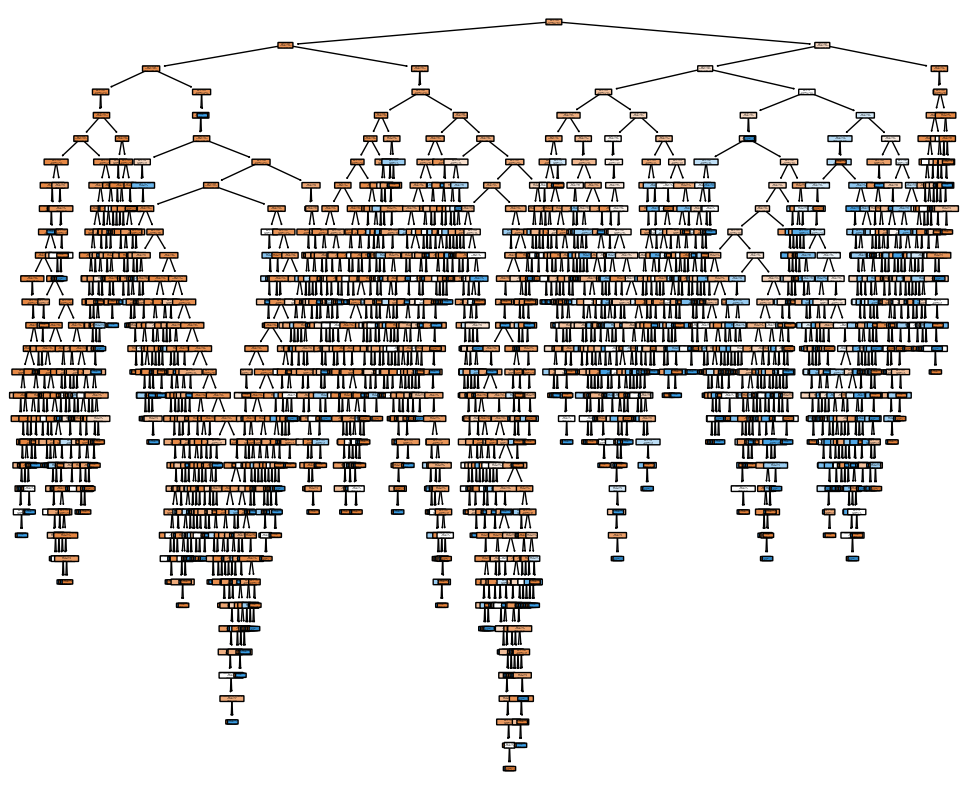

In [31]:
plt.figure(figsize=(12,10))  # Adjust the fqigure size as needed
tree.plot_tree(dtree, feature_names=features, filled=True, rounded=True)

# Adjust dpi for higher qualit
plt.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'PigEBank_Decision Tree.png'), dpi=300)  

plt.show()


## 4. Evaluating out put of model using confusion matrix

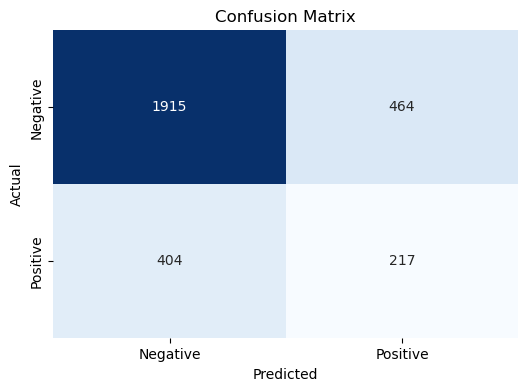

In [32]:
# Import confusion matrix
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, pred_test)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False, 
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## 5. Optimizing Decision Tree Performance

In [33]:
# Create Decision Tree classifer object
# Use maximum depth as acontrol variable for pre-pruning
# other variable to use is gini
dtree1 = DecisionTreeClassifier(criterion="gini", max_depth=4, random_state = 2)

# Train Decision Tree Classifer
dtree1 = dtree1.fit(X_train,y_train)

#Predict the response for test dataset
pred_test = dtree1.predict(X_test)

# Model performance: Accuracy, how often is the classifier correct?
# F1-Score ranges from 0 to 1, where a higher value indicates better model performance
print("Accuracy for test dataset:",metrics.accuracy_score(y_test, pred_test))
print("F1-Score for test dataset:",metrics.f1_score(y_test, pred_test))

Accuracy for test dataset: 0.8106666666666666
F1-Score for test dataset: 0.4021052631578947


The acuracy of classifcation rate improves from 71 % to 81% after pre-pruning by using a maximum depth of 4.

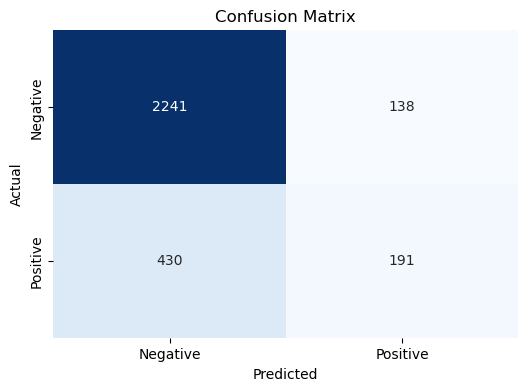

In [34]:
# Import confusion matrix
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, pred_test)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False, 
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
### Visualize decision tree graph using graphviz

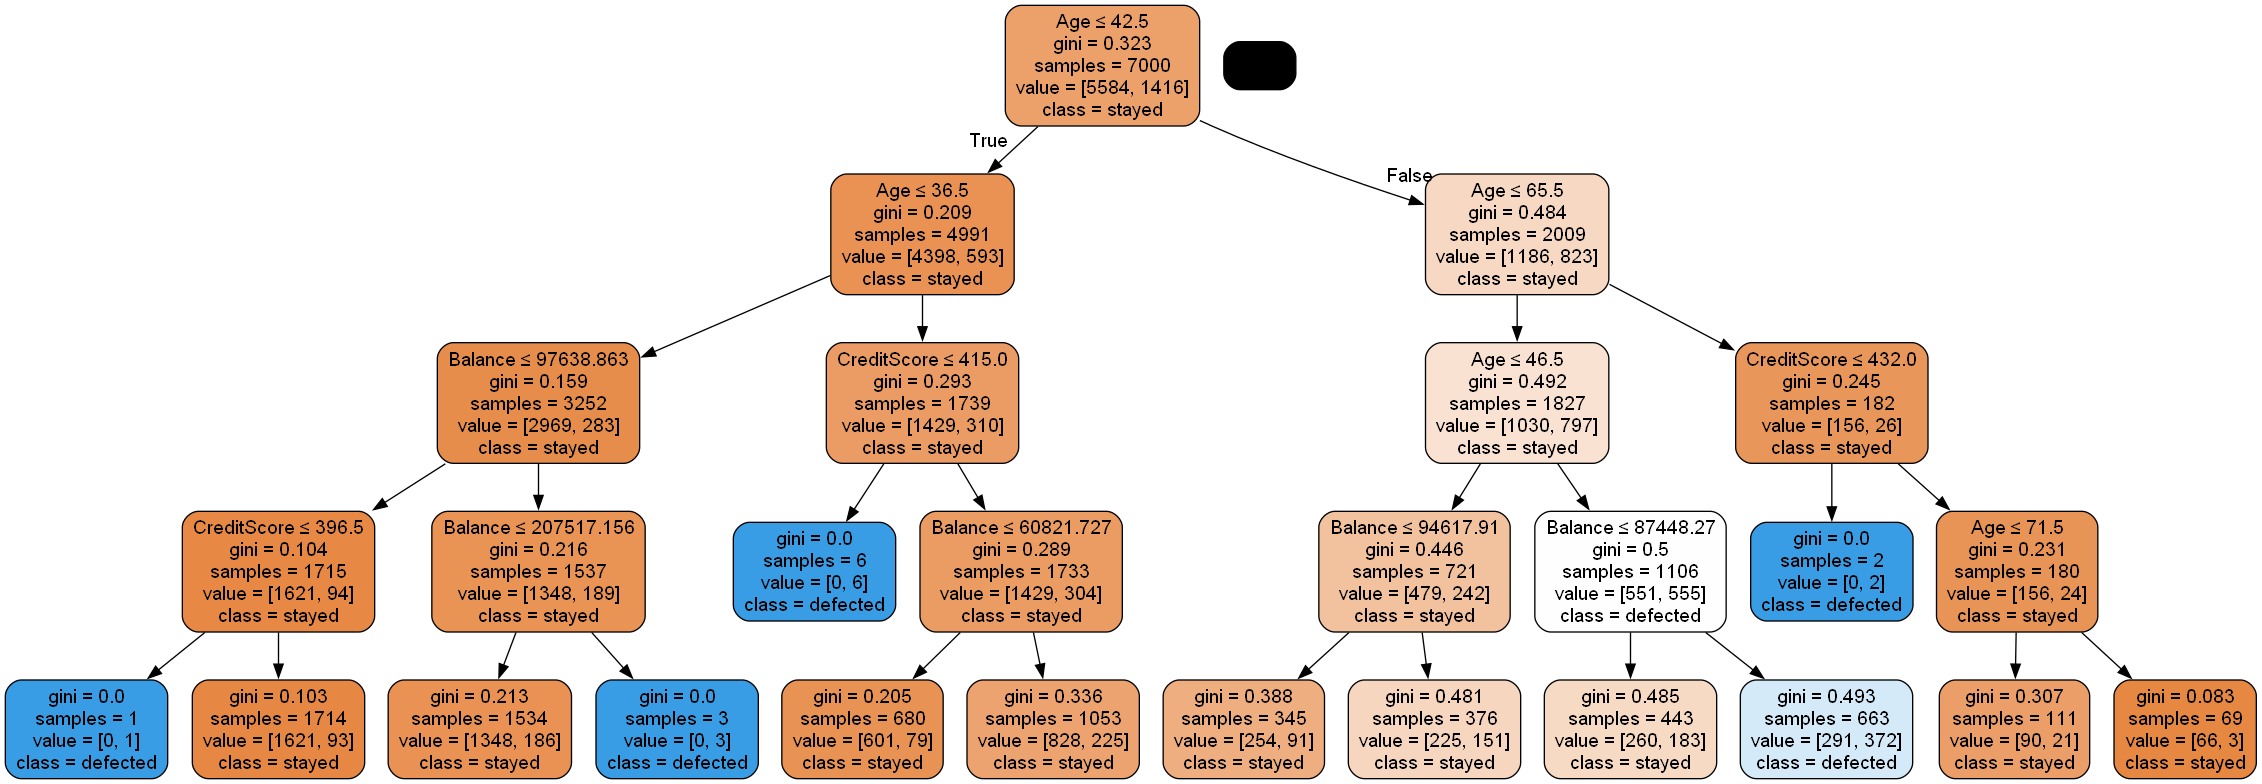

In [35]:
from io import StringIO
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
import os

dot_data = StringIO()
export_graphviz(dtree1, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = features,class_names=['stayed','defected'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(os.path.join(path, '04 Analysis', 'Visualizations', 'PigEBank_Decision Tree_pruned2.png'))
Image(graph.create_png())

The pruned decision tree model is less complex, and easier to understand that the unpruned decision tree.

In [37]:
# Create Decision Tree classifer object
# Use maximum depth as acontrol variable for pre-pruning
# other variable to use is gini
dtree1 = DecisionTreeClassifier(criterion="gini", max_depth=3, random_state = 2)

# Train Decision Tree Classifer
dtree2 = dtree1.fit(X_train,y_train)

#Predict the response for test dataset
pred_test2 = dtree2.predict(X_test)

# Model performance: Accuracy, how often is the classifier correct?
# F1-Score ranges from 0 to 1, where a higher value indicates better model performance
print("Accuracy for test dataset:",metrics.accuracy_score(y_test, pred_test2))
print("F1-Score for test dataset:",metrics.f1_score(y_test, pred_test2))

Accuracy for test dataset: 0.805
F1-Score for test dataset: 0.4863915715539947


In [41]:
# Create Decision Tree classifer object
# Use maximum depth as acontrol variable for pre-pruning
# other variable to use is gini
dtree1 = DecisionTreeClassifier(criterion="gini", max_depth=5, random_state = 2)

# Train Decision Tree Classifer
dtree2 = dtree1.fit(X_train,y_train)

#Predict the response for test dataset
pred_test2 = dtree2.predict(X_test)

# Model performance: Accuracy, how often is the classifier correct?
# F1-Score ranges from 0 to 1, where a higher value indicates better model performance
print("Accuracy for test dataset:",metrics.accuracy_score(y_test, pred_test2))
print("F1-Score for test dataset:",metrics.f1_score(y_test, pred_test2))

Accuracy for test dataset: 0.803
F1-Score for test dataset: 0.31990794016110474


The model does not improve when maximum depth is set at 3 and 5.